In [309]:
import gmsh
import numpy as np


In [310]:
E = 30e6   # en psi 
v = 0.3    
T = 1000   # tension en psi
largo = 10  # en pulgadas
altura = 5 # en pulgadas
espesor = 1 # en pulgadas
radio = 1 # en pulgadas
gl = 2

In [311]:
gmsh.initialize()
gmsh.model.add('Chapa 1/4')

lc = 10

# defino los puntos 
p1 = gmsh.model.geo.addPoint(0, 0, 0, lc)
p2 = gmsh.model.geo.addPoint(0, altura, 0, lc) 
p3 = gmsh.model.geo.addPoint(largo, altura, 0, lc) 
p4 = gmsh.model.geo.addPoint(largo, 0, 0, lc) 
p5 = gmsh.model.geo.addPoint(radio, 0, 0, lc/5)
p6 = gmsh.model.geo.addPoint(0, radio, 0, lc/5)

# defino las lineas 

l1 = gmsh.model.geo.addLine(p6, p2)
l2 = gmsh.model.geo.addLine(p2, p3)
l3 = gmsh.model.geo.addLine(p3, p4)
l4 = gmsh.model.geo.addLine(p4, p5)
l5 = gmsh.model.geo.addCircleArc(p5,p1,p6) # semicirculo

# defino bordes
#C1 = gmsh.model.geo.addCurveLoop([l1, l2, l3, l4, l5])
C1 = gmsh.model.geo.addCurveLoop([l1,l2,l3,l4])
C2 = gmsh.model.geo.addCurveLoop([l5])

# defino superficie
S1 = gmsh.model.geo.addPlaneSurface([C1,C2])

# descarto el punto 1, usado para generar el semicirculo
trash = gmsh.model.addPhysicalGroup(0, [p1])
gmsh.model.setPhysicalName(0,trash, "trash")

gmsh.model.geo.synchronize()

# defino grupos fisicos
Fijos_X = gmsh.model.addPhysicalGroup(1, [l1])
gmsh.model.setPhysicalName(1,Fijos_X,'Fijos_X')

Fijos_Y = gmsh.model.addPhysicalGroup(1, [l4])
gmsh.model.setPhysicalName(1,Fijos_Y,'Fijos_Y')

Traccionado = gmsh.model.addPhysicalGroup(1, [l3])
gmsh.model.setPhysicalName(1,Traccionado,'Traccionado')

Superficie = gmsh.model.addPhysicalGroup(2,[S1])
gmsh.model.setPhysicalName(2,Superficie, 'Superficie')

gmsh.model.mesh.generate(2)

In [312]:
NodeInfo = gmsh.model.mesh.get_nodes() 
NumeroNodos = NodeInfo[0].shape[0]
MN = NodeInfo[1].reshape(NumeroNodos , 3) # obtengo la matriz de nodos 

ElementInfo = gmsh.model.mesh.get_elements()
ETAGS, ELEMENTS = gmsh.model.mesh.get_elements_by_type(2) # aca estan los triangulos que forman el mallado
MC = ELEMENTS.reshape([ETAGS.shape[0],3]) # matriz de conectividad de los triangulos 



# Para sacar los índices de los nodos que estan empotrados y traccionados, 
# defino una 'entidad' para los elements Traccionados:
NodosTraccionados = gmsh.model.mesh.get_nodes_for_physical_group(1,Traccionado)
entityTraccionada = gmsh.model.getEntitiesForPhysicalGroup(1, Traccionado)
Tgroup, Ttraccionada, Ltraccionada = gmsh.model.mesh.getElements(1, entityTraccionada[0])
Ltraccionada = Ltraccionada[0].reshape(Ttraccionada[0].shape[0],2)

# Con los elementos líneas traccionadas se calculan las longitudes de las lineas, para poder distribuir la fuerza externa

Longitudes = np.abs(MN[Ltraccionada[:,0]-1,1] - MN[Ltraccionada[:,1]-1,1])

Fuerzas = np.zeros((2*NumeroNodos,1))

for l, linea in enumerate(Ltraccionada):
    Flocal = np.array([[1],[1]])*T*espesor*Longitudes[l]/2
    n1 = linea[0]
    n2 = linea[1]
    Fuerzas[ np.array([2*(n1-1), 2*(n2-1)], dtype=int)] += Flocal
    
# Las fuerzas en X estan en las filas 0,2,etc:
Fuerzas_X = Fuerzas[0::2]

# Las fuerzas en Y estan en las filas 1,3,etc:
Fuerzas_Y = Fuerzas[1::2]

# Los nodos empotrados en X y en Y son:
   
NodosFijos_X = gmsh.model.mesh.get_nodes_for_physical_group(1,Fijos_X)
NodosFijos_Y = gmsh.model.mesh.get_nodes_for_physical_group(1,Fijos_Y)

# Los nodos de los triangulos son:
Nodos_Triangulos = gmsh.model.mesh.get_nodes_for_physical_group(2,Superficie)      

# El punto auxiliar p1 es:
Nodo_Trash = gmsh.model.mesh.get_nodes_for_physical_group(0,trash)  

# genero s (posiciones de los desplazamientos conocidos) y r (posiciones de las fuerzas conocidas)
s = []
r = np.arange(2*NumeroNodos)

# for n, nodo in enumerate(NodosFijos_X[0]):
#    s.append(np.linspace(2*nodo, 2*nodo +1, 2))

#for n, nodo in enumerate(NodosFijos_Y[0]):
#    s.append(np.linspace(2*nodo, 2*nodo +1, 2))

    
#s = np.array(s).astype(int).reshape(1,-1)
#r = np.delete(r, s)  # elimino del vector r lo que esta en s, porque son complementarios

s = np.hstack(
    [   2*(NodosFijos_Y[0]-1),               
        2*(NodosFijos_X[0]-1)+1,
        2*(Nodo_Trash[0]-1),                 
        2*(Nodo_Trash[0]-1)+1 ])

r = np.delete( r , s )



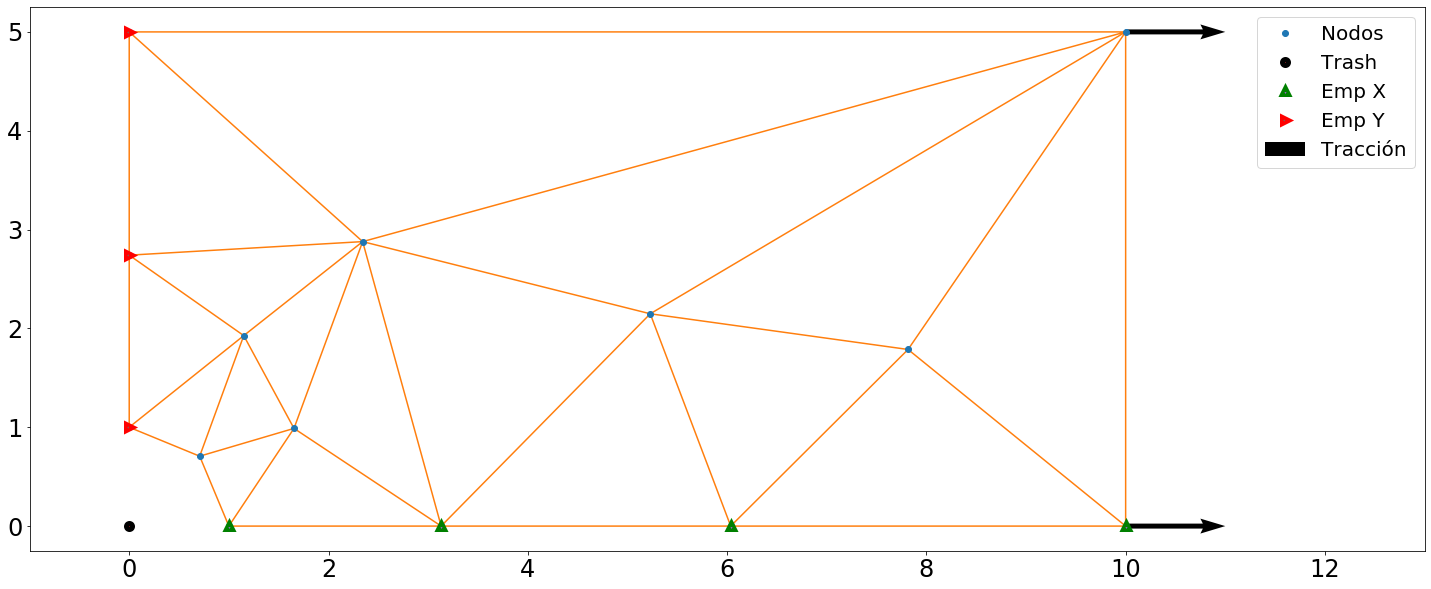

In [317]:
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(25,10))
plt.rc('axes', labelsize=24 )
plt.rc('xtick', labelsize=24 )
plt.rc('ytick', labelsize=24 )
plt.rc('legend', fontsize=20)
plt.xlim([-1, largo+3])

plt.plot(MN[Nodos_Triangulos[0]-1, 0], MN[Nodos_Triangulos[0]-1,1], 'o', label='Nodos')
plt.triplot(MN[Nodos_Triangulos[0]-1, 0], MN[Nodos_Triangulos[0]-1, 1], MC-MC.min())
plt.plot(MN[Nodo_Trash[0]-1, 0], MN[Nodo_Trash[0]-1, 1,], "o", markeredgewidth=5, markeredgecolor='k', label="Trash")
plt.plot(MN[NodosFijos_Y[0]-1, 0], MN[NodosFijos_Y[0]-1, 1], "^", markeredgecolor='g', markeredgewidth=5, label='Emp X')
plt.plot(MN[NodosFijos_X[0]-1, 0], MN[NodosFijos_X[0]-1, 1], ">", markeredgecolor='r', markeredgewidth=5, label='Emp Y' )
plt.quiver(MN[Ltraccionada[::2].reshape(len(Ltraccionada)+1,1)-1, 0], MN[Ltraccionada[::2].reshape(len(Ltraccionada)+1,1)-1, 1],  Fuerzas_X[Ltraccionada[::2].reshape(len(Ltraccionada)+1,1)[:,0]-1], Fuerzas_Y[Ltraccionada[::2].reshape(len(Ltraccionada)+1,1)[:,0]-1],scale=2500, units="x", width=0.05, label='Tracción')

plt.legend()

In [294]:
s

array([ 6,  8, 14, 16,  3, 11, 13,  0,  1], dtype=uint64)

Genero las matrices D y B. Armo las matrices de rigidez locales y las voy ensamblando en la matriz de rigidez global 

In [295]:
D = (E/(1-v**2)) * np.array([(1, v, 0), (v,1,0), (0,0,0.5*(1-v))])
B=[]
matriz_coordenadas = np.ones((3,3))
K = np.zeros([gl*NumeroNodos,gl*NumeroNodos])

# le resto 1 a la MC para que quede coherente lo que obtengo de gmesh con la numeracion de python, sino queda fuera de rango 
MC=MC-1

for e in range(len(MC)):
    
    
    nodo_i = int( MC[e][0]  )
    nodo_j = int( MC[e][1]  )
    nodo_m = int( MC[e][2]  )
    
    
    beta_i  = MN[nodo_j][1] - MN[nodo_m][1]
    beta_j  = MN[nodo_m][1] - MN[nodo_i][1]
    beta_m  = MN[nodo_i][1] - MN[nodo_j][1]
    gamma_i = MN[nodo_m][0] - MN[nodo_j][0]
    gamma_j = MN[nodo_i][0] - MN[nodo_m][0]
    gamma_m = MN[nodo_j][0] - MN[nodo_i][0]

        
    matriz_coordenadas[:,0] = MN[nodo_i][0],MN[nodo_j][0],MN[nodo_m][0]
    matriz_coordenadas[:,1] = MN[nodo_i][1],MN[nodo_j][1],MN[nodo_m][1]
    A = np.linalg.det(matriz_coordenadas)/2
    
    B.append((1/(2*A)) * np.array([(beta_i, 0, beta_j, 0, beta_m, 0),
                                   (0,gamma_i, 0, gamma_j, 0, gamma_m),
                                   (gamma_i, beta_i, gamma_j, beta_j, gamma_m, beta_m)]))
    
    k = espesor*A* np.matmul(np.transpose(B[e]), np.matmul(D,B[e]))

    for i in MC[e]:
        columna_i = list(MC[e]).index(i) # identifico en que columna de MC esta el elemento i
        #index_i = np.add(np.linspace(i*gl,(i+1)*gl-1,gl).astype(int) , np.array([-1,-1]))
        index_i = np.linspace(i*gl, (i+1)*gl -1, gl).astype(int)
        ind_col_i = np.linspace(columna_i*gl,(columna_i+1)*gl-1,gl).astype(int)
        for j in MC[e]:
            columna_j = list(MC[e]).index(j) # # identifico en que columna de MC esta el elemento j
            # index_j = np.add(np.linspace(j*gl,(j+1)*gl-1,gl).astype(int) , np.array([-1,-1]) )
            index_j = np.linspace(j*gl, (j+1)*gl -1, gl).astype(int)
            ind_col_j = np.linspace(columna_j*gl,(columna_j+1)*gl-1,gl).astype(int)
            K[np.ix_(index_i, index_j)] +=  k[np.ix_(ind_col_i , ind_col_j)]


Ahora, armo la matriz reducida y resuelvo. Primero obtengo los desplazamientos que no tenia, luego armo el vector desplazamientos completo y finalmente obtengo el vector tensiones completo. 

In [300]:
K_reducida = K.copy()
# borro filas y columnas de las posiciones de U que ya tengo
K_reducida = np.delete(K_reducida, s, axis=0)
K_reducida = np.delete(K_reducida, s, axis=1)

#Todos los desplazamientos que conozco son 0, armo el vector desplazamientos U:
U = np.zeros(len(s))

# obtengo las U que no conozco:
nuevas_U = np.linalg.solve(K_reducida, Fuerzas[r]) 

U_global = np.zeros(NumeroNodos*gl)
k=0
z=0
# k y z son contadores que van recorriendo en orden los vectores U y nuevas_U



for i in range(len(U_global)):
    if i in s:
        U_global[i] = U[k]
        k += 1

    if i in r:
        U_global[i] = nuevas_U[z]
        z += 1

        
Fuerzas = np.matmul(K,U_global)

# calculo esfuerzos
Tensiones = []


for e in range(len(MC)):
    nodo_i = int(MC[e][0] -1)
    nodo_j = int(MC[e][1] -1)
    nodo_m = int(MC[e][2] -1)

    desplazamientos = np.array([(U_global[2*nodo_i],U_global[(2*nodo_i)+1], U_global[2*nodo_j],U_global[(2*nodo_j)+1], U_global[2*nodo_m],U_global[(2*nodo_m)+1])])
    tensiones.append(np.matmul(D, np.matmul(B[e], np.transpose(desplazamientos))))

print(len(Fuerzas))
print('')
print(Fuerzas)
print('')
print(len(U_global))
print('')
print(U_global)

30

[    0.     0.   256. -1856.  2304.   384. -2176.  1920.  -512.   -96.
    80.  -320.  -512.  -576. -1536.  -448.  -576.    64.   128.   -32.
  -384. -2496.   320.   256.  -608.  -512.  2304.  -832.   512.  -192.]

30

[ 0.00000000e+00  0.00000000e+00  9.12218792e+10  0.00000000e+00
  9.12218792e+10 -1.82443758e+11  0.00000000e+00 -1.82443758e+11
  0.00000000e+00 -1.82443758e+10  1.82443758e+10  0.00000000e+00
  5.00094497e+10  0.00000000e+00  0.00000000e+00 -1.10131784e+11
  0.00000000e+00 -5.71148202e+10  1.29007219e+10 -1.29007218e+10
  3.91908980e+10 -9.53997315e+10  1.80342631e+10 -3.01688283e+10
  5.25124329e+10 -4.27422273e+10  3.26031943e+10 -1.42604758e+11
  3.51607311e+10 -2.09715200e+10]


In [301]:
# Desplazamientos en X son las posiciones 0,2, etc del vector U_global:
Desplazamientos_X = U_global[::2]
# Desplazamientos en Y son las posiciones 1,3, etc del vector U_global:
Desplazamientos_Y = U_global[1::2]
# Fuerzas en X son las posiciones 0,2, etc del vector fuerzas:
Fuerzas_X = Fuerzas[::2]
# Fuerzas en Y son las posiciones 1,3,etc del vector fuerzas:
Fuerzas_Y = Fuerzas[1::2]



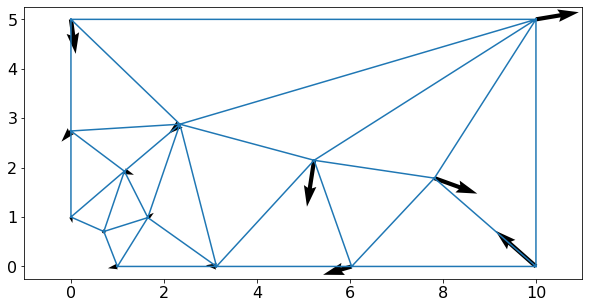

In [306]:
plt.rc('figure', figsize=(10,5))
plt.rc('axes', labelsize=24 )
plt.rc('xtick', labelsize=16 )
plt.rc('ytick', labelsize=16 )
plt.rc('legend', fontsize=20)
plt.triplot(MN[Nodos_Triangulos[0]-1, 0], MN[Nodos_Triangulos[0]-1, 1], MC-MC.min())
plt.xlim([-1, largo+1])
plt.quiver(MN[1:,0], MN[1:,1], Fuerzas_X[1:], Fuerzas_Y[1:], units='x',scale=2500)
